In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Un

In [1]:
path = "/content/drive/MyDrive/AnimalClassification/"

In [2]:
import zipfile
import zipfile
import pandas as pd
import glob
from PIL import Image
import numpy as np
import csv
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator for training with normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Min-Max scaling to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15          # 15% of training data for validation
)

# Define ImageDataGenerator for testing with normalization
test_datagen = ImageDataGenerator(
    rescale=1./255,                # Min-Max scaling to [0,1]
    validation_split=0.15          # 15% of testing data for validation
)

In [4]:
# Paths
import os
# combined_dataset_path = '/content/drive/My Drive/AnimalBreedClassification/aumentated/combinedData/'    # Replace with your path
output_split_path = '/content/drive/MyDrive/AnimalClassification/'          # Replace with your path

# Assuming you have already split the dataset into 'train' and 'test' directories
train_directory = os.path.join(output_split_path, 'train')
test_directory = os.path.join(output_split_path, 'test')

# Create Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),         # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    subset='training',              # Set as training data
    shuffle=True,
    seed=42
)

# Create Validation Generator from Training Data
validation_generator = train_datagen.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',            # Set as validation data
    shuffle=True,
    seed=42
)

# Create Testing Generator
test_generator = test_datagen.flow_from_directory(
    directory=test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5430 images belonging to 15 classes.
Found 945 images belonging to 15 classes.
Found 1126 images belonging to 15 classes.


In [5]:
# 1. Import necessary libraries
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# 2. Load the ResNet50 model with pre-trained weights, without top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# 3. Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global pooling to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
predictions = Dense(15, activation='softmax')(x)  # Output layer for 3 classes

# 4. Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# 5. Freeze the base model layers (ResNet50)
for layer in base_model.layers:
    layer.trainable = False

# 6. Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 [==============================] - 0s 0us/step


In [6]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [7]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to the training and testing directories
train_directory = '/content/drive/MyDrive/AnimalClassification/train'
test_directory = '/content/drive/MyDrive/AnimalClassification/test'

# Define ImageDataGenerator for training with augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define ImageDataGenerator for validation/testing with only normalization
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create Training Generator
train_generator = train_datagen.flow_from_directory(
    directory=train_directory,
    target_size=(224, 224),         # Resize images to 224x224
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Create Validation Generator
validation_generator = test_datagen.flow_from_directory(
    directory=test_directory,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 6375 images belonging to 15 classes.
Found 1126 images belonging to 15 classes.


In [8]:
# 7. Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=10
)

# 8. Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/10
200/200 [==============================] - 2433s 12s/step - loss: 2.5247 - accuracy: 0.1920 - val_loss: 2.3123 - val_accuracy: 0.2522
Epoch 2/10
200/200 [==============================] - 1538s 8s/step - loss: 2.2550 - accuracy: 0.2962 - val_loss: 2.1482 - val_accuracy: 0.3384
Epoch 3/10
200/200 [==============================] - 1482s 7s/step - loss: 2.1342 - accuracy: 0.3445 - val_loss: 2.0587 - val_accuracy: 0.4005
Epoch 4/10
200/200 [==============================] - 1496s 7s/step - loss: 2.0495 - accuracy: 0.3769 - val_loss: 1.8826 - val_accuracy: 0.4245
Epoch 5/10
200/200 [==============================] - 1492s 7s/step - loss: 1.9781 - accuracy: 0.3984 - val_loss: 1.9015 - val_accuracy: 0.4254
Epoch 6/10
200/200 [==============================] - 1481s 7s/step - loss: 1.9237 - accuracy: 0.4223 - val_loss: 1.8045 - val_accuracy: 0.5027
Epoch 7/10
200/200 [==============================] - 1478s 7s/step - loss: 1.8730 - accuracy: 0.4472 - val_loss: 1.7941 - val_accuracy

In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Get the ground truth labels for the test dataset
Y_test = validation_generator.classes

# Predict the probabilities
Y_pred = model.predict(validation_generator)

# Convert predictions to class labels (choosing the class with highest probability)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

36/36 [==============================] - 211s 6s/step
Confusion Matrix:
 [[34  0 15  2 10  5  0  0  1  3  2  1  0  0  2]
 [ 1 31  5  8  7  4  5  2  4  3  3  1  0  0  1]
 [ 1  0 71  1  2  0  0  0  0  0  0  0  0  0  0]
 [ 4  1  2 47  2  3  1  3  0  2  2  1  2  2  3]
 [ 4  0  1  4 55  3  3  0  1  1  0  0  2  0  1]
 [ 0  0  1  2  0 57  0  4  5  4  0  0  0  0  2]
 [ 1  0  1  2  2  3 48  3  1  3  2  1  2  3  3]
 [ 0  0  2  3  3  8  0 39  4  4  5  0  1  4  2]
 [ 4  0  1  5  1 11  2  4 21 14  8  1  1  0  2]
 [ 1  0  0  0  1  1  2  3 11 44  2  0  3  3  4]
 [ 1  1  1  0  2  5  1  5  1  4 46  1  1  2  5]
 [ 0  0  1  4  2  1  3 14  2  5  2 21  6 11  3]
 [ 0  0  2  1  2  0  5  6  1  4  0  1 41  6  6]
 [ 4  0  0  1  5  0  4  8  1  1  2  1  5 41  2]
 [ 0  0  1  0  2  3  1  8  3  2  3  0  4  3 45]]


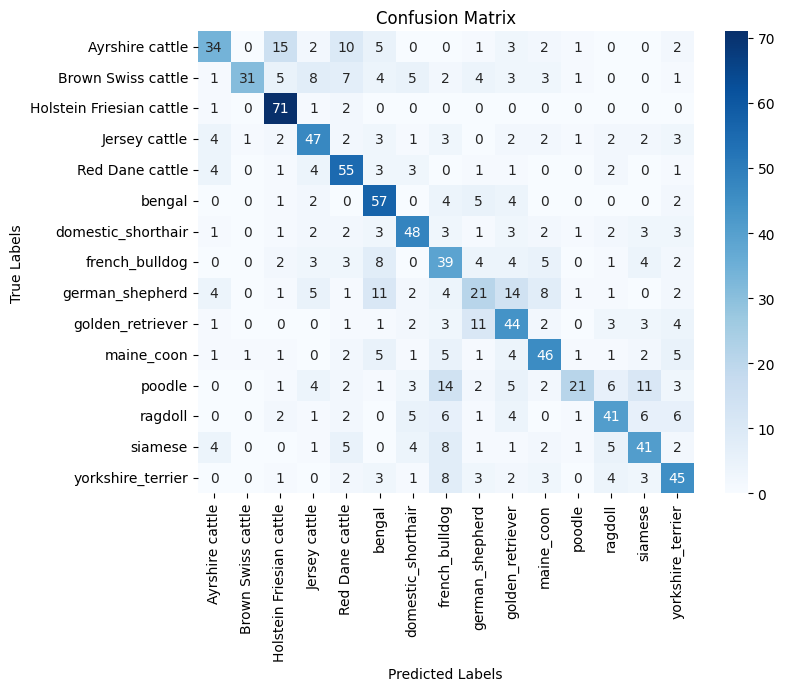

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [11]:
# Classification Report: Precision, Recall, F1-score for each class
class_report = classification_report(Y_test, Y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
                           precision    recall  f1-score   support

         Ayrshire cattle       0.62      0.45      0.52        75
      Brown Swiss cattle       0.94      0.41      0.57        75
Holstein Friesian cattle       0.68      0.95      0.79        75
           Jersey cattle       0.59      0.63      0.61        75
         Red Dane cattle       0.57      0.73      0.64        75
                  bengal       0.55      0.76      0.64        75
      domestic_shorthair       0.64      0.64      0.64        75
          french_bulldog       0.39      0.52      0.45        75
         german_shepherd       0.38      0.28      0.32        75
        golden_retriever       0.47      0.59      0.52        75
              maine_coon       0.60      0.61      0.60        76
                  poodle       0.72      0.28      0.40        75
                 ragdoll       0.60      0.55      0.57        75
                 siamese       0.55      0.55      

In [12]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# 1. Get true labels from the validation generator
Y_test = validation_generator.classes  # True labels

# 2. Predict classes for validation data
Y_pred_probs = model.predict(validation_generator, steps=len(validation_generator))  # Predicted probabilities
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)  # Convert probabilities to class labels

# 3. Get class labels (class indices as names)
class_labels = list(validation_generator.class_indices.keys())

# 4. Classification Report
class_report = classification_report(Y_test, Y_pred_classes, target_names=class_labels, output_dict=True)

# Extract overall metrics (weighted average)
precision = class_report['weighted avg']['precision']
recall = class_report['weighted avg']['recall']
f1_score = class_report['weighted avg']['f1-score']
support = class_report['weighted avg']['support']

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred_classes)

# Print results
print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1-Score: {f1_score:.2f}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy:.2f}")

36/36 [==============================] - 212s 6s/step
Overall Precision: 0.59
Overall Recall: 0.57
Overall F1-Score: 0.56
Support: 1126.0
Accuracy: 0.57


In [ ]:
# 7. Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=20
)

# 8. Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/20
200/200 [==============================] - 2155s 11s/step - loss: 2.5036 - accuracy: 0.1887 - val_loss: 2.2104 - val_accuracy: 0.3428
Epoch 2/20
200/200 [==============================] - 1801s 9s/step - loss: 2.2289 - accuracy: 0.3048 - val_loss: 2.1907 - val_accuracy: 0.3277
Epoch 3/20
200/200 [==============================] - 1816s 9s/step - loss: 2.1200 - accuracy: 0.3489 - val_loss: 2.0039 - val_accuracy: 0.4520
Epoch 4/20
200/200 [==============================] - 1805s 9s/step - loss: 2.0467 - accuracy: 0.3743 - val_loss: 1.9600 - val_accuracy: 0.3952
Epoch 5/20
200/200 [==============================] - 1810s 9s/step - loss: 1.9605 - accuracy: 0.4086 - val_loss: 1.8690 - val_accuracy: 0.4494
Epoch 6/20
200/200 [==============================] - 1802s 9s/step - loss: 1.9011 - accuracy: 0.4320 - val_loss: 1.7329 - val_accuracy: 0.5409
Epoch 7/20
200/200 [==============================] - 1804s 9s/step - loss: 1.8592 - accuracy: 0.4453 - val_loss: 1.8641 - val_accuracy

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

# 7. Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=20,
    callbacks=callbacks  # Add callbacks here
)

# 8. Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test accuracy: {test_acc * 100:.2f}%")


Epoch 1/20
200/200 [==============================] - 1892s 9s/step - loss: 2.5187 - accuracy: 0.1958 - val_loss: 2.3858 - val_accuracy: 0.2158
Epoch 2/20
200/200 [==============================] - 1852s 9s/step - loss: 2.2556 - accuracy: 0.2877 - val_loss: 2.1710 - val_accuracy: 0.3428
Epoch 3/20
200/200 [==============================] - 1897s 9s/step - loss: 2.1382 - accuracy: 0.3487 - val_loss: 2.1335 - val_accuracy: 0.3188
Epoch 4/20
200/200 [==============================] - 1850s 9s/step - loss: 2.0615 - accuracy: 0.3656 - val_loss: 2.0421 - val_accuracy: 0.3375
Epoch 5/20
200/200 [==============================] - 1836s 9s/step - loss: 1.9893 - accuracy: 0.3998 - val_loss: 1.8891 - val_accuracy: 0.4751
Epoch 6/20
200/200 [==============================] - 1874s 9s/step - loss: 1.9432 - accuracy: 0.4100 - val_loss: 1.9292 - val_accuracy: 0.4121
Epoch 7/20
200/200 [==============================] - 1863s 9s/step - loss: 1.8936 - accuracy: 0.4218 - val_loss: 1.8348 - val_accuracy:

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

# Get the ground truth labels for the test dataset
Y_test = validation_generator.classes

# Predict the probabilities
Y_pred = model.predict(validation_generator)

# Convert predictions to class labels (choosing the class with highest probability)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

36/36 [==============================] - 299s 8s/step
Confusion Matrix:
 [[50  1 20  2  2  0  0  0  0  0  0  0  0  0  0]
 [12 42  7  5  0  0  0  0  7  0  0  2  0  0  0]
 [ 5  0 70  0  0  0  0  0  0  0  0  0  0  0  0]
 [18  5  8 38  1  0  0  0  0  0  0  3  1  0  1]
 [31  2  3  6 28  0  0  0  3  0  0  0  2  0  0]
 [ 6  3  2  1  1 44  0  1 12  1  0  2  0  0  2]
 [ 7  2  1  3  0  0 44  0  6  0  1  4  4  2  1]
 [ 5  2  5  3  1  1  0 25 10  1  1 15  2  2  2]
 [ 7  2  5  5  0  1  0  0 45  2  1  4  3  0  0]
 [ 2  3  1  2  0  0  0  0 18 34  0  7  3  2  3]
 [ 5  1  2  1  1  0  1  1  9  0 46  4  1  2  2]
 [ 5  3  2  3  1  1  1  1  5  1  1 37  6  7  1]
 [ 1  0  2  6  2  0  2  0  1  0  0  4 52  4  1]
 [11  1  1  5  1  0  0  1  1  0  2  4 11 36  1]
 [ 4  0  2  3  0  0  1  0  8  1  0  5  6  1 44]]


In [ ]:
# Classification Report: Precision, Recall, F1-score for each class
class_report = classification_report(Y_test, Y_pred_classes, target_names=validation_generator.class_indices.keys())
print("Classification Report:\n", class_report)

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred_classes)
print(f"Accuracy: {accuracy:.2f}")

Classification Report:
                           precision    recall  f1-score   support

         Ayrshire cattle       0.30      0.67      0.41        75
      Brown Swiss cattle       0.63      0.56      0.59        75
Holstein Friesian cattle       0.53      0.93      0.68        75
           Jersey cattle       0.46      0.51      0.48        75
         Red Dane cattle       0.74      0.37      0.50        75
                  bengal       0.94      0.59      0.72        75
      domestic_shorthair       0.90      0.59      0.71        75
          french_bulldog       0.86      0.33      0.48        75
         german_shepherd       0.36      0.60      0.45        75
        golden_retriever       0.85      0.45      0.59        75
              maine_coon       0.88      0.61      0.72        76
                  poodle       0.41      0.49      0.45        75
                 ragdoll       0.57      0.69      0.63        75
                 siamese       0.64      0.48      

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# 1. Get true labels from the validation generator
Y_test = validation_generator.classes  # True labels

# 2. Predict classes for validation data
Y_pred_probs = model.predict(validation_generator, steps=len(validation_generator))  # Predicted probabilities
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)  # Convert probabilities to class labels

# 3. Get class labels (class indices as names)
class_labels = list(validation_generator.class_indices.keys())

# 4. Classification Report
class_report = classification_report(Y_test, Y_pred_classes, target_names=class_labels, output_dict=True)

# Extract overall metrics (weighted average)
precision = class_report['weighted avg']['precision']
recall = class_report['weighted avg']['recall']
f1_score = class_report['weighted avg']['f1-score']
support = class_report['weighted avg']['support']

# Accuracy
accuracy = accuracy_score(Y_test, Y_pred_classes)

# Print results
print(f"Overall Precision: {precision:.2f}")
print(f"Overall Recall: {recall:.2f}")
print(f"Overall F1-Score: {f1_score:.2f}")
print(f"Support: {support}")
print(f"Accuracy: {accuracy:.2f}")


36/36 [==============================] - 257s 7s/step
Overall Precision: 0.00
Overall Recall: 0.07
Overall F1-Score: 0.01
Support: 1126.0
Accuracy: 0.07


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
